# Introduction: Insights from "Helpful" Product Reviews

Many e-commerce sites offer users the opportunity to post their own reviews of products they have purchased. These reviews contain a wealth of information about users' experiences with a company's products, and other users may read these reviews when considering making a purchase. But because reviews consist mainly of user-generated text, it can be difficult for a business to extract insights from thousands of them. 

On some e-commerce sites, users have the opportunity to rate another user's product review as "helpful" or not, and analyzing these "helpful" reviews can help a business understand what its customers want to know about its products before buying. At the very least, being able to identify and promote potentially "helpful" reviews, even without directly analyzing their contents, could help potential customers get the information they need sooner.

This project aims to answer these two questions:
- What can we learn about a business's products and its customers from user-generated reviews that were rated "helpful" by other users?
- Can we predict whether a review will be rated "helpful" using machine learning or deep learning?

The [dataset I used for this project comes from Amazon (via Kaggle)](https://www.kaggle.com/snap/amazon-fine-food-reviews) and consists of over 500,000 reviews, mostly of food products, written between 2002 and 2012.

## Summay of findings

(For more, see _Interpretations and Recommendations_ below.)

- "Helpful" reviews are very difficult to distinguish from the rest using this dataset. 
- Using a neural network, "helpful" reviews can be identified with 59% validation accuracy. This model could be used to sort submitted reviews so that the ones most likely to be "helpful" can be displayed first.
- "Helpful" reviews of food products reflect concerns about taste, ingredients, and packaging. Offering clearer information on these subjects in product descriptions could improve user experience.
- The most "helpful" _reviewers_ can be identified and offered incentives to review products. These reviewers tend to write many reviews and to rate products positively, so recognizing their contributions could be beneficial both to the business and to potential customers.

## Costs and benefits of this project

Any data science project can have costs and benefits, both in terms of resources like time and computing power, and in terms of the project's potential impact on human beings. Here is a summary of what I see as the pros and cons of the work I do here:

_Benefits_
- A business can learn about its products and customers.
- If a business improves its product or website based on things learned here, customers may have a better user experience.

_Costs_
- Machine learning, and especially deep learning, can be costly in terms of labor, computing power, and energy use.
- The dataset consists of user-generated reviews, and some users could potentially be identified by their profile names or by information they provided in their reviews. Although users originally posted their reviews knowing that they would be publicly visible, they did not have the opportunity to choose whether their data would appear in this dataset. 

## About this repo

This repository contains the following files:
- **helpful_reviews_classification.ipynb**: a Jupyter Notebook containing the code for this project.

The full dataset can be downloaded at [https://www.kaggle.com/snap/amazon-fine-food-reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews).

For more technical details, see the Appendix below.

# Analysis of "helpful" reviews

What can we learn about a business's products and its customers from user-generated reviews that were rated "helpful" by other users? In this section I try to discover the following:

- Key words and phrases in "helpful" v. unhelpful (or unrated) reviews
- Any relationships between "helpfulness" and a review's positivity, length, or other features
- Any patterns in the content, structure, or narrative style of "helpful" reviews that might inform business decisions (particularly decisions about how to describe products on the company website)
- Problems or weird things to watch out for in a collection of user-generated reviews

## Load data

Let's load in the data so we can get started.

In [0]:
# Load the first packages we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
# Read in the data
data = pd.read_csv('./data/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# View the column datatypes and counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


The dataset contains the following variables:
- `Id`: a unique identifier for each review
- `ProductId`: a unique identifier for each product being reviewed
- `UserId`: a unique identifier for each reviewer
- `ProfileName`: the display name of each reviewer
- `HelpfulnessNumerator`: the number of "helpful" votes each review received
- `HelpfulnessDenominator`: the total number of votes on helpfulness (upvotes and downvotes)
- `Score`: the reviewer's rating of the product, in number of stars from 1 to 5
- `Time`: a timestamp for each review
- `Summary`: a brief headline or title for each review
- `Text`: the text of each review.

`HelpfulnessNumerator` is the target I'll try to predict in the modeling section below. For most of my analysis, I focus on `Text`. I don't use `Time` at all because I expect that most interaction with product reviews is asynchronous, i.e., a review could be written and then rated "helpful" the same day or years later.

## Initial exploration and cleaning

### Check for duplicates

With such a large dataset, one of my first concerns is whether it contains many duplicate entries. In particular, I am concerned about:

- true duplicate entries, i.e., the exact same review of the same product by the same person, and
- "spam" entries, i.e., the exact same text posted to multiple products.

In [0]:
# Check for multiple reviews of same product
data.ProductId.value_counts()

B007JFMH8M    913
B0026RQTGE    632
B002QWP89S    632
B002QWHJOU    632
B002QWP8H0    632
             ... 
B008QPBSXE      1
B001YJ2VGM      1
B003PM4X9E      1
B004D6UAWK      1
B0084JFD7E      1
Name: ProductId, Length: 74258, dtype: int64

It makes sense that there would be multiple reviews of some products, so these value counts are not unexpected. 

In [0]:
# Check for multiple reviews by same user
data.UserId.value_counts()

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A1N15DDUYPDXVO      1
A2JXHUQYM3OXH7      1
A2B8TQ3M0VRKV8      1
A3EEZ8YWOTBR2W      1
A36ZJ8VITNWRBC      1
Name: UserId, Length: 256059, dtype: int64

It's also reasonable that some reviewers write many reviews, but 448 reviews is quite a lot! Let's see how many times the same combinations of products and reviewers are repeated.

In [0]:
# Look for duplicate reviews using ProductId + UserId
dupes = data.duplicated(subset=['ProductId', 'UserId'])
dupes.sum()

7650

So it seems there may be 7,650 times where the same user reviewed the same product more than once. Let's try to inspect some examples and see if we can figure out what's going on.

In [0]:
# Investigate a potential duplicate reviewer
dupes[dupes == True]

426       True
429       True
435       True
467       True
485       True
          ... 
568056    True
568060    True
568062    True
568067    True
568144    True
Length: 7650, dtype: bool

I'll focus on the review at index 429. 

In [0]:
# Investigate a potential duplicate reviewer
data.iloc[429,]

Id                                                                                                                                                                                                                                                                                                                                                                                       430
ProductId                                                                                                                                                                                                                                                                                                                                                                         B000G6RYNE
UserId                                                                                                                                                                                                                                        

At first glance, I have no reason to believe that this is not a legitimate review, other than the fact that it was flagged as a duplicate. The `ProfileName` sounds like a real person (not a garbled alphanumeric string like I might expect from a bot), and the review reads like something a real person might say. There are no phishy-looking links or other weird things in the text itself.

Let's take a deeper dive into "Scrapper's" reviews.

In [0]:
# Check out all reviews by 'Scrapper'
scrapper = data[data.UserId == 'A1IRN1M05TPOVT']
scrapper.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,49.000000,49.000000,49.000000,49.000000,4.900000e+01
mean,309519.102041,0.224490,0.224490,4.979592,1.319677e+09
std,192180.078790,0.654004,0.654004,0.142857,2.135026e+07
min,424.000000,0.000000,0.000000,4.000000,1.243901e+09
25%,112884.000000,0.000000,0.000000,5.000000,1.316477e+09
50%,331780.000000,0.000000,0.000000,5.000000,1.331078e+09
75%,481356.000000,0.000000,0.000000,5.000000,1.334621e+09
max,552864.000000,4.000000,4.000000,5.000000,1.334621e+09


"Scrapper" seems to have very positive opinions of the products she reviews, although she doesn't score a lot of "helpful" ratings.

How many duplicate reviews has she produced?

In [0]:
# See how many potentially duplicate reviews Scrapper produced
scrapper.ProductId.value_counts()

B0058AMY5G    2
B000LKXBL4    2
B001SAXPEO    2
B0058AMY10    2
B000G6MBUA    2
B000LKVD5U    2
B0012XBD7I    2
B006WYSFZK    2
B000G6RYNE    2
B004728MI4    2
B00472I5A4    2
B0058AMYTC    2
B0058AMY74    2
B000G6O2QG    2
B005C955WC    1
B00018CWZW    1
B000KGW2BY    1
B004ASBLJ2    1
B000H27NU6    1
B00017LEZC    1
B000EQT77M    1
B003FDG468    1
B001HBXO54    1
B003V8QGAG    1
B0089Q2AAA    1
B003ZXFWP2    1
B003V8Y7DE    1
B004VJ9UCA    1
B0089Q2A8M    1
B000EQX6QK    1
B003V8WNIK    1
B002DZIL24    1
B000HVVMQI    1
B002YJCA30    1
B000E1FZIW    1
Name: ProductId, dtype: int64

It looks like she reviewed the first 14 products twice each. That's weird, but not _that_ weird; maybe she just wanted to review those products more than once.

What about the texts of her reviews? Are they duplicated?

In [0]:
# View Scrapper's duplicate reviews
scrapper.Text.value_counts()

I have never met a Kettle brand chip I did not like. These chips have a great loaded potato flavor, which are flavorful. I like the sweet onion chips better, but these are also at the top of the list for great-tasting potato chips. Kettle chips are great chips f/the money!                                                                                     14
WOW!  I have eaten quite a few potato chips in my day. Kettle chips are the BEST non-baked chips I have eaten. I decided to try the sweet onion chips, since I've never had them. I now have a FAVORITE!! If you like onions, this is a MUST buy! I will definitely reorder these, as I mentioned above, they are the BEST I have ever eaten! The flavor is GREAT.    14
These are some of the BEST chips I have ever eaten! Since they were popped and not fried, they have a fresh, non-greasy taste! I would recommend these to anyone watching their diet. FANTASTIC!!                                                                                     

"Scrapper" has written 36 non-unique reviews. Something is fishy! Why would a person post the exact same review 14 times across various products? This is not behavior I would expect from a "normal" customer who is leaving genuine reviews on products they actually purchased. 

Are there other "Scrappers" in this dataset?

In [0]:
# Find all duplicate review texts
data.Text.value_counts()[:2]

This review will make me sound really stupid, but whatever. I don't really care as long as people find out what's real and can avoid my mistakes.<br /><br />I got my wonderful little sweet Bella Bean when she was a few days shy of three years old. She had been bounced around from house to house and eating whatever was cheap. I have had cats around me my entire life, for about twenty-five years now. My mother always just fed them whatever, the kinds of food you buy in the supermarket - Friskies, Nine Lives, Kit & Kaboodle, stuff like that. And our cats were always fine, at least in terms of their eating habits. They would eat in the morning, stop when they were done, come back, and eat some more when they got hungry.<br /><br />My housemate at the time was working for Hill's and assured me that this was the best food ever made, so great, so on and so forth. I now know that she is an utter buffoon, but I initially trusted her judgment, which is so unfortunate because she doesn't think. S

The first review in this printout occurs 199 times in the dataset. I can't imagine any normal circumstance under which a genuine customer would post this exact text that many times. 

I think it would be safe to consider any non-unique review text as spam and remove all but the first instance from the dataset. How many spam reviews are there?

In [0]:
# Count non-unique review texts
dupe_texts = data.duplicated(subset=['Text'])
dupe_texts[dupe_texts == True].count()

174875

Almost 175,000 of the review texts are non-unique! They must go.

In [0]:
# Select just the unique reviews
data_no_dupe_texts = data.drop_duplicates(subset=['Text'])

In [0]:
# Check counts and missing values
data_no_dupe_texts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393579 entries, 0 to 568453
Data columns (total 10 columns):
Id                        393579 non-null int64
ProductId                 393579 non-null object
UserId                    393579 non-null object
ProfileName               393568 non-null object
HelpfulnessNumerator      393579 non-null int64
HelpfulnessDenominator    393579 non-null int64
Score                     393579 non-null int64
Time                      393579 non-null int64
Summary                   393576 non-null object
Text                      393579 non-null object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


Now I can be confident that I am dealing with unique reviews. 

### Determine how to handle `HelpfulnessNumerator`

Below I'm going to use `HelpfulnessNumerator` as the target for my predictions, so first I need to know more about this variable. How is it distributed? And should I treat it as continuous or categorical?

Let's check the distribution first.

In [0]:
# Check summary stats on helpfulness votes
data_no_dupe_texts.HelpfulnessNumerator.describe()

count    393579.000000
mean          1.733535
std           6.873517
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

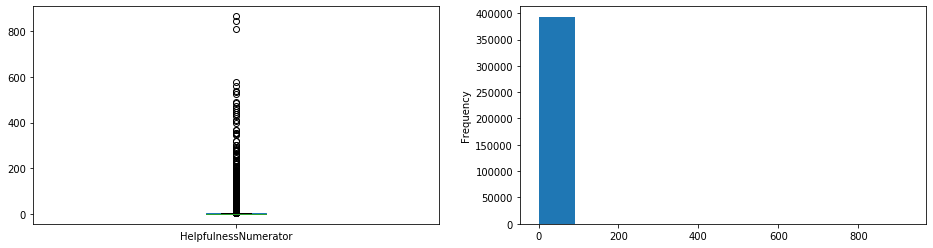

In [0]:
# Visualize the distribution of values
fig, axes = plt.subplots(1, 2, figsize=(16,4))

ax1 = axes[0]
data_no_dupe_texts.HelpfulnessNumerator.plot(kind='box', ax=ax1)

ax2 = axes[1]
data_no_dupe_texts.HelpfulnessDenominator.plot(kind='hist', ax=ax2)

plt.show();

From these plots and the summary stats above I can see that a large number of reviews received no "helpful" votes, while a very small number received huge numbers of "helpful" votes.

When it comes time for modeling, I will treat this as a classification problem and create a boolean column to record whether a review received 0 helpful votes or more than 0. 

### Calculate lengths of reviews

In the section below, I'm going to check for correlations between `HelpfulnessNumerator` and other variables, and I want the length of each review to be one of them. I'll calculate that here.

In [0]:
# Calculate a column for character lengths of review texts
data_no_dupe_texts['Text_len'] = [len(data_no_dupe_texts.loc[row, 'Text']) for row in data_no_dupe_texts.index]
data_no_dupe_texts.head()

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140


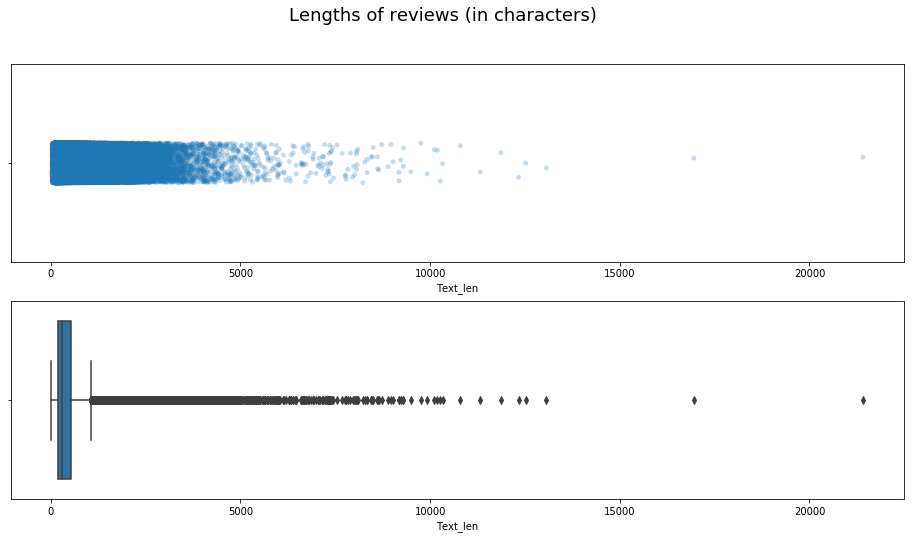

In [0]:
# Visualize lengths of reviews (in characters)
fig, axes = plt.subplots(2, 1, figsize=(16,8))
ax1 = axes[0]
sns.stripplot(x='Text_len', data=data_no_dupe_texts, alpha=0.25, ax=ax1)

ax2 = axes[1]
sns.boxplot(x='Text_len', data=data_no_dupe_texts, ax=ax2)
plt.suptitle('Lengths of reviews (in characters)', fontsize=18)

plt.show();

In [0]:
# Get summary stats on Text_len
data_no_dupe_texts.Text_len.describe()

count    393579.000000
mean        433.829178
std         433.002351
min          12.000000
25%         181.000000
50%         304.000000
75%         527.000000
max       21409.000000
Name: Text_len, dtype: float64

It appears that the vast majority of reviews are pretty short, i.e., well under 1,000 characters. But there are also some really long-winded reviews that are several thousand characters long. Apparently there was no character limit on the input form, or if there was, it was set well over 20,000 characters.

### Check for correlations with "helpfulness"

Before I go to the trouble of trying to predict helpfulness from the texts of reviews, I want to see if any of my other variables could do the same job. Here I'll check for correlations between `HelpfulnessNumerator` and several other variables, both ones that came in the dataset and some new ones I engineered.

In [0]:
# Get a copy of data_no_dupe_texts
data = data_no_dupe_texts.copy()

First, I'll create a new variable to represent how many times a product's ID occurs in the dataset.

In [0]:
# Create `ProductIdCount` variable
prod_id_counts = data.ProductId.value_counts()
data['ProductIdCount'] = [prod_id_counts[idx] for idx in data['ProductId']]

Next I'll create a boolean column to indicate whether a product's `ProductIdCount` is in the top 1%. This gives me a handy way to separate the most frequently reviewed products from those that weren't reviewed very often.

In [0]:
# Create `ProductMostReviewed` variable
data['ProductMostReviewed'] = np.where(data['ProductIdCount'] > np.quantile(prod_id_counts, 0.99), 1, 0)

Now I'll do something similar for `UserId`: calculate how many times each `UserId` occurs, and calculate whether a given `UserId` is in the top 1% most common IDs.

In [0]:
# Calculate similar columns for `UserId`
user_id_counts = data.UserId.value_counts()
data['UserIdCount'] = [user_id_counts[idx] for idx in data['UserId']]

data['TopReviewer'] = np.where(data['UserIdCount'] > np.quantile(user_id_counts, 0.99), 1, 0)

Rather than deal with the somewhat confusing `HelpfulnessDenominator` column, I will calculate the difference between it and `HelpfulnessNumerator` as a new column called `Downvotes`. This will represent the number of times someone voted negatively on the helpfulness of a review. Keep in mind that many reviews received no votes on helpfulness either way.

In [0]:
# Calculate `Downvotes` column
data['Downvotes'] = data['HelpfulnessDenominator'] - data['HelpfulnessNumerator']

Now let's take a look at all the columns just to review what we have:

In [0]:
# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393579 entries, 0 to 568453
Data columns (total 16 columns):
Id                        393579 non-null int64
ProductId                 393579 non-null object
UserId                    393579 non-null object
ProfileName               393568 non-null object
HelpfulnessNumerator      393579 non-null int64
HelpfulnessDenominator    393579 non-null int64
Score                     393579 non-null int64
Time                      393579 non-null int64
Summary                   393576 non-null object
Text                      393579 non-null object
Text_len                  393579 non-null int64
ProductIdCount            393579 non-null int64
ProductMostReviewed       393579 non-null int64
UserIdCount               393579 non-null int64
TopReviewer               393579 non-null int64
Downvotes                 393579 non-null int64
dtypes: int64(11), object(5)
memory usage: 51.0+ MB


Now I'm ready to check for correlations among the variables.

In [0]:
# Calculate Pearson coefficient of correlation
data_for_corr = data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time',
                           'HelpfulnessDenominator', 'Summary', 'Text'], 
                          axis=1)

data_for_corr.corr()

,HelpfulnessNumerator,Score,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes
HelpfulnessNumerator,1.000000,-0.036113,0.172175,-0.002520,0.010340,0.009040,0.005662,0.225819
Score,-0.036113,1.000000,-0.068555,-0.016376,-0.028534,0.017774,-0.003941,-0.282804
Text_len,0.172175,-0.068555,1.000000,0.076947,0.094800,0.177398,0.227655,0.061923
ProductIdCount,-0.002520,-0.016376,0.076947,1.000000,0.743660,0.010863,0.098177,0.008076
ProductMostReviewed,0.010340,-0.028534,0.094800,0.743660,1.000000,0.010548,0.102361,0.017622
UserIdCount,0.009040,0.017774,0.177398,0.010863,0.010548,1.000000,0.579754,-0.011029
TopReviewer,0.005662,-0.003941,0.227655,0.098177,0.102361,0.579754,1.000000,-0.008282
Downvotes,0.225819,-0.282804,0.061923,0.008076,0.017622,-0.011029,-0.008282,1.000000


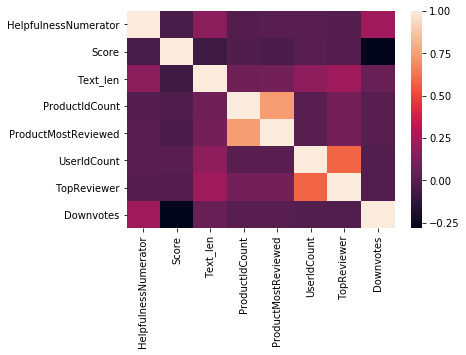

In [0]:
# Visualize correlation coefficients as a heatmap
sns.heatmap(data_for_corr.corr());

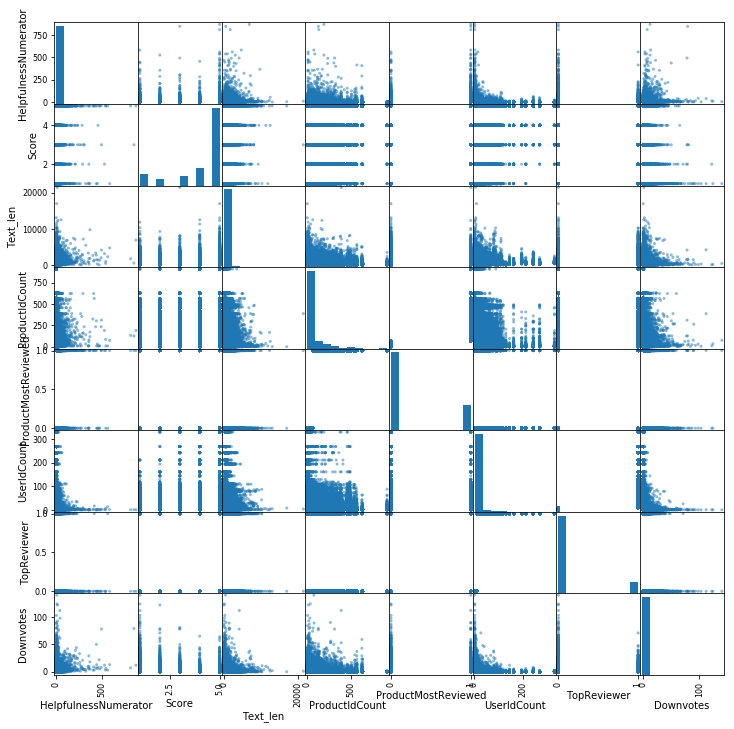

In [0]:
# Look for linear relationships
pd.plotting.scatter_matrix(data_for_corr, 
                           figsize=(12,12));

There are several important insights to be gained here:
- `HelpfulnessNumerator` is not strongly correlated with any of the other variables. 
- The only strong correlations are between variables that are calculated from one another (e.g., `UserIdCount` and `TopReviewer`.
- Because `HelpfulnessNumerator` is not strongly correlated with `Score` or `Text_len`, I can infer that "helpful" reviews can be of any length and of any degree of positivity/negativity.
- The corpus of reviews skews positive in sentiment; a rating of 5/5 is by far the most common score.

Given these outcomes, it seems that we must turn to the texts of the reviews themselves to try to predict helpfulness; other variables just won't do the job.

### View the most and least "helpful" reviews

I think it's worthwhile to do some qualitative analysis of the most and least "helpful" reviews. This may help me make better decisions when it comes time to engineer features on the texts themselves (e.g., tokenization, n-grams).

In [0]:
# View the most "helpful" review
pd.options.display.max_colwidth = 100
data[data.HelpfulnessNumerator == max(data.HelpfulnessNumerator)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes
190733,190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,866,878,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />******************<br /><br />I was lamenting about only ...,6918,190,1,1,0,12


In [0]:
# View the full text of this review 
pd.options.display.max_colwidth = 7000
data[data.HelpfulnessNumerator == max(data.HelpfulnessNumerator)]['Text']

190733    see update at end of review<br /><br />******************<br /><br />I was lamenting about only having frech lettuce, herbs, chives, and tomatoes from may garden during the long fall-winter-spring parts of the year. The refrigerated stuff from the grocery store goes bad right away and does not taste as good as the fresh stuff from the garden, either.<br /><br />Then I saw a Time Magazine page on the new AeroGrow AeroGarden, and I just had to try it out. After reading the AeroGrow website before making the purchase, I realized that buying one garden would not work for me, as the tomatoes cannot be grown in the same garden as lettuce & herbs. This is partially due to the large amount of room taken up by the tomatoes, and also because the lamp/watering cycle is different and finally because the nutrients are different.<br /><br />So, I bought two gardens, along with the Salad Greens seed kit and Cherry Tomato seed kit. Each garden comes with a mixed herb kit, so I figured to mix

Here are my initial observations on this review:
- The review received 866 upvotes and 12 downvotes on its helpfulness.
- It has a narrative arc starting with a problem, leading to the discovery of the product, and then the process of using the product to solve the problem.
- It contains lots of details about the product itself, including how it works, what parts it contains, what supplementary parts the user had to purchase, etc.
- The reviewer contributed only this one review to the dataset.
- The product itself was in the top 1% most reviewed products.

Let's do the same for the review with the most downvotes.

In [0]:
# View review with most downvotes
pd.options.display.max_colwidth = 100
data[data.Downvotes == max(data.Downvotes)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes
470626,470627,B001LUM1ZU,A1H6VW0W3UIK0K,"Tyler Durden ""The first rule of amazon.com is...",5,145,1,1243555200,Should be illegal...,As if mayonnaise wasn't unhealthy enough for you they have to add bacon to it now! And we wonde...,495,76,1,1,0,140


In [0]:
# View the full text of this review 
pd.options.display.max_colwidth = 500
data[data.Downvotes == max(data.Downvotes)]['Text']

470626    As if mayonnaise wasn't unhealthy enough for you they have to add bacon to it now!  And we wonder why the heart disease rate is so high in our country.  In fact, more americans DIE every year from Salmonela poisoning than from swine flu, lightning strikes and roadside bombs combined!  Look it up!  I can't wait to be President so we can outlaw mayonnaise and put the criminals who make it behind bars where they belong and in this instance, THE DEATH PENALTY for wasting perfectly good bacon!!!
Name: Text, dtype: object

Some observations on this review:
- The review received 5 upvotes and 140 downvotes on helpfulness.
- The reviewer's profile name contains references to <i>Fight Club</i>, which matches the cynical tone of the review.
- It lacks the problem-product-solution arc of the most helpful review; instead, it has a harsh tone throughout and climaxes with a call for capital punishment for the product's makers.
- The product is among the top 1% most reviewed products.
- The reviewer contributed only this one review to the dataset.

Keep in mind that readers don't have to vote on the helpfulness of a review at all; they can simply read it and move on. These two reviews represent extreme cases where readers were motivated to vote up or down on helpfulness instead of just scrolling past. 

### Meet the top reviewers

#### The most prolific reviewer

In [0]:
# Identify the reviewer who wrote the most reviews
pd.options.display.max_colwidth = 100
gary = data[data.UserIdCount == max(data.UserIdCount)]
gary.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,1316390400,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh and Easy Neighborhood Grocery looking over possibl...,741,3,0,329,1,0
2196,2197,B008YAXFWI,AY12DBB0U420B,Gary Peterson,0,0,4,1346630400,"Mild Taste, But Delicious.",A nearby Fresh and Easy Neighborhood Market stocks a number of gourmet imported products and I e...,461,1,0,329,1,0
3016,3017,B0025UALB6,AY12DBB0U420B,Gary Peterson,0,0,4,1316736000,Good Nutrition and Right Size.,"When I'm working, I always carry my own lunch. It's so much better than the food court, and I ha...",1026,5,0,329,1,0
3528,3529,B005TY2REE,AY12DBB0U420B,Gary Peterson,0,0,4,1333756800,No cholesterol. No Sodium. Not Very Sweet. Good Taste.,In my trip through the health area of my local food market I stumbled upon Enjoy Life Boom Choco...,540,1,0,329,1,0
3826,3827,B000X2CWTM,AY12DBB0U420B,Gary Peterson,1,1,5,1263340800,Mmmmmmmm!,I've always liked licorice candy and the best licorice I've ever had was obtained at Ikea. It wa...,552,37,0,329,1,0


In [0]:
# View summary stats
gary.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes
count,329.000000,329.000000,329.000000,329.000000,3.290000e+02,329.000000,329.000000,329.000000,329.0,329.0,329.000000
mean,270291.358663,1.124620,1.234043,4.659574,1.321395e+09,820.571429,16.410334,0.039514,329.0,1.0,0.109422
std,170106.232415,2.728514,2.968831,0.657676,3.073342e+07,298.758848,50.576783,0.195110,0.0,0.0,0.390672
min,110.000000,0.000000,0.000000,2.000000,1.226880e+09,385.000000,1.000000,0.000000,329.0,1.0,0.000000
25%,99740.000000,0.000000,0.000000,4.000000,1.316822e+09,618.000000,1.000000,0.000000,329.0,1.0,0.000000
50%,271766.000000,0.000000,0.000000,5.000000,1.333757e+09,746.000000,3.000000,0.000000,329.0,1.0,0.000000
75%,409657.000000,1.000000,1.000000,5.000000,1.341187e+09,939.000000,13.000000,0.000000,329.0,1.0,0.000000
max,566680.000000,20.000000,22.000000,5.000000,1.350950e+09,2516.000000,456.000000,1.000000,329.0,1.0,2.000000


In [0]:
# View just the review texts
pd.options.display.max_colwidth = 1000
for n in gary.index[:5]:
    print(gary.loc[n, 'Text'])
    print('\n')

I'm presently on a diet and I was at my Fresh and Easy Neighborhood Grocery looking over possible diet foods. I wanted things that were tasty, non-fat and low in calories. I came home with about a dozen items. That's how I discovered the Tillen Farms Pickled Crispy Asparagus. Well, I've always liked asparagus anyway and I've enjoyed several brands of pickled asparagus. This Tillen Farms brand is really, really good! It's the best I can recall. There's an excellent flavor and a big clove of garlic down in  the bottom of the jar which I'm looking forward to eating. I can't believe how good this asparagus tastes and right on the front it says "only 60 calories per jar!" Now this is my idea of a good diet food!<br /><br />Gary Peterson


A nearby Fresh and Easy Neighborhood Market stocks a number of gourmet imported products and I enjoy trying them. One is a variety of Baxters soups from Canada. Today, I had the Butternut Squash and Red Pepper Soup. Quite good. Smooth and mellow. Mild tast

The most prolific reviewer in the dataset is "Gary Peterson," who contributed 329 reviews. As the sample above shows, his reviews are generally positive, very focused on health/nutritional concerns, and structured with a narrative arc from problem to product to solution. 

I'm surprised to see that "Gary Peterson" frequently describes purchasing the reviewed product at a local store, not on Amazon. There could be many other reviewers who left reviews on Amazon for products purchased elsewhere, but I don't have a convenient way to distinguish them in the dataset.

Now I'll do another calculated column to identify the reviewer who received the most helpful votes overall (i.e., the sum of the `HelpfulnessNumerator` field after grouping by `UserId`.

#### The most "helpful" reviewer

In [0]:
# Calculate each reviewer's total number of "helpful" votes
user_help_votes = data.groupby('UserId')['HelpfulnessNumerator'].sum()
data['UserHelpVotes'] = [user_help_votes[index] for index in data['UserId']]

In [0]:
# Identify the reviewer who received the most "helpful" votes
pd.options.display.max_colwidth = 100
data[data.UserHelpVotes == max(data.UserHelpVotes)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes,UserHelpVotes
190733,190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,866,878,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />******************<br /><br />I was lamenting about only ...,6918,190,1,1,0,12,866


The most "helpful" reviewer is "P. Schmidt," author of the top-rated review of the Aerogarden above. Although it was his only review in the dataset, it scored him more "helpful" votes than any of the other reviewers scored across their reviews combined.

#### Top 1% most "helpful" reviewers

"P. Schmidt" may be an exceptional case, so let's examine the top 1% of reviewers by the number of "helpful" votes they received. This may shed light on what makes a review "helpful."

In [0]:
data['TopHelpfulReviewer'] = (np.where(data.UserHelpVotes 
                                       > np.quantile(data.UserHelpVotes, 0.99), 
                                       1, 0))

top_reviewers = data[data.TopHelpfulReviewer == 1]
top_reviewers.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes,UserHelpVotes,TopHelpfulReviewer
count,3934.000000,3934.000000,3934.000000,3934.000000,3.934000e+03,3934.000000,3934.000000,3934.000000,3934.000000,3934.000000,3934.000000,3934.000000,3934.0
mean,264659.066090,9.189120,9.992374,4.364769,1.270157e+09,1076.556431,47.129893,0.175648,131.789019,0.973310,0.803254,410.090239,1.0
std,167756.273853,47.233695,48.942464,1.026667,6.000326e+07,970.785615,96.152128,0.380569,93.532109,0.161197,3.108992,169.581905,0.0
min,110.000000,0.000000,0.000000,1.000000,9.828000e+08,57.000000,1.000000,0.000000,1.000000,0.000000,0.000000,234.000000,1.0
25%,111146.750000,0.000000,0.000000,4.000000,1.230185e+09,535.000000,3.000000,0.000000,67.000000,1.000000,0.000000,289.000000,1.0
50%,261036.500000,1.000000,2.000000,5.000000,1.278288e+09,808.000000,10.000000,0.000000,94.000000,1.000000,0.000000,359.000000,1.0
75%,408640.250000,4.000000,5.000000,5.000000,1.325117e+09,1286.000000,34.000000,0.000000,211.000000,1.000000,1.000000,485.000000,1.0
max,568250.000000,866.000000,923.000000,5.000000,1.351037e+09,10269.000000,909.000000,1.000000,329.000000,1.000000,79.000000,866.000000,1.0


Insights on top 1% most helpful reviewers:
- Most of the products they review are not in the top 1% most reviewed products. One of these very helpful reviewers provided the sole review of a particular product. But several these reviewers also reviewed the most reviewed product (oatmeal cookies).
- They are prolific: 97% of the most helpful reviewers are also in the top 1% most active reviewers.
- On average they received 0.8 downvotes; their reviews motivate people to click "helpful" but are uncontroversial.
- On average they receive 9 "helpful" votes per review.
- They tend to be positive; the average score is 4.36 stars.
- The average review by one of these reviewers is more than twice as long as the average review overall.

#### The most frequently reviewed product

Finally, let's examine the most frequently reviewed product to see what we can learn from its reviews.

In [0]:
# View the reviews of the most-reviewed product
cookies = data[data.ProductIdCount == max(data.ProductIdCount)]
cookies.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes,UserHelpVotes
562970,562971,B007JFMH8M,A368Z46FIKHSEZ,"jaimoi ""Appreciator of good music""",0,0,5,1343433600,Delicious!,I love these cookies! Not only are they healthy but they taste great and are so soft! I will d...,135,909,1,1,0,0,0
562971,562972,B007JFMH8M,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",0,0,5,1343433600,Great Anytime of Day!,"Quaker Soft Baked Oatmeal Cookies with raisins are a delicious treat, great for anytime of day. ...",1316,909,1,24,1,0,20
562972,562973,B007JFMH8M,A2Z9JNXPIEL2B9,carwash169,0,0,5,1343433600,Very good!,"I am usually not a huge fan of oatmeal cookies, but these literally melt in your mouth. They are...",261,909,1,1,0,0,0
562973,562974,B007JFMH8M,A31CYJQO3FL586,"P. Titus ""Knitgirlll""",0,0,5,1343433600,Quaker Oats Oatmeal Raisin Mom Voxbox Review Courtesy of Influenster,"I participated in a product review that included a sample of <a href=""http://www.amazon.com/gp/p...",530,909,1,1,0,0,0
562974,562975,B007JFMH8M,A2KXQ2EKFF3K2G,Jessica,0,0,5,1343433600,"Quick, simple HEALTHY snack for the kiddos!!!",My kids loved these. I was very pleased to give my kids a quick on the go healthy snack before s...,169,909,1,1,0,0,0


The Quaker Soft-Baked Oatmeal Cookie is the most-reviewed product, with over 900 reviews in the dataset. Let's check the summary stats:

In [0]:
# View summary stats
cookies.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_len,ProductIdCount,ProductMostReviewed,UserIdCount,TopReviewer,Downvotes,UserHelpVotes
count,909.000000,909.000000,909.000000,909.000000,9.090000e+02,909.000000,909.0,909.0,909.000000,909.000000,909.000000,909.000000
mean,563427.156216,0.045105,0.050605,4.580858,1.342416e+09,285.096810,909.0,1.0,2.720572,0.067107,0.005501,2.097910
std,263.753046,0.295246,0.317743,0.706567,1.021681e+06,247.596525,0.0,0.0,6.761760,0.250344,0.087630,14.106513
min,562971.000000,0.000000,0.000000,1.000000,1.341792e+09,87.000000,909.0,1.0,1.000000,0.000000,0.000000,0.000000
25%,563199.000000,0.000000,0.000000,4.000000,1.341878e+09,146.000000,909.0,1.0,1.000000,0.000000,0.000000,0.000000
50%,563428.000000,0.000000,0.000000,5.000000,1.341965e+09,205.000000,909.0,1.0,1.000000,0.000000,0.000000,0.000000
75%,563655.000000,0.000000,0.000000,5.000000,1.342742e+09,325.000000,909.0,1.0,1.000000,0.000000,0.000000,0.000000
max,563883.000000,5.000000,5.000000,5.000000,1.351123e+09,3535.000000,909.0,1.0,88.000000,1.000000,2.000000,319.000000


Scores skew positive, as is typical for this dataset, and reviews are a bit shorter than average (285 v. 433 characters). 

Let's read some of the reviews: 

In [0]:
# View the review texts
for n in cookies.index[:15]:
    print(cookies.loc[n, 'Text'])
    print('\n')

I love these cookies!  Not only are they healthy but they taste great and are so soft!  I will definitely add these to my grocery list!


Quaker Soft Baked Oatmeal Cookies with raisins are a delicious treat, great for anytime of day.  For example:<br /><br />--at breakfast, I had one with a large banana and a cup of coffee, and felt I'd had a relatively "healthy" start to the day.<br /><br />--the next day at lunch, following a tuna sandwich, I had one with a glass of milk, and was satisfied enough to not need a snack before dinner at 6:30.<br /><br />--the following night, after dinner, I had one with the remainder of my glass of wine. (Delicious!) And again, didn't feel the need to snack later in the evening.<br /><br />Each cookie is individually packaged, and their texture is soft and moist, with just the right amount of sweetness. Natural flavors used in the making are Cinnamon and All Spice.  These flavorings give the cookies a real old-fashioned, homemade taste.<br /><br />Nutri

A number of reviews of this product were related to promotions offered by other companies (not Amazon alone). Apparently, some reviewers were offered free samples in exchange for a review. Since reviews in exchange for products may be biased, let's take a closer look at the "helpful" cookie reviews.

In [0]:
# View "helpful" reviews of the cookies
pd.options.display.max_colwidth = 1000
cookies[cookies.HelpfulnessNumerator > 0]['Text'].head()

563070                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Ok so I love oatmeal cookies they are amazing. And this is one that I approve on for its soft gooey and chewy. It is absolutely amazing. I love it, and would recommend it to anyone that loves oatmeal, and the raisins are sweet they do not taste tart and are not overpowering.
563071    I love oatmeal raisin cookies, really love them.  So, I am always on the lookout for a good cookie...especially if they

In [0]:
# Compare "unhelpful" reviews
pd.options.display.max_colwidth = 2000
cookies[cookies.HelpfulnessNumerator == 0]['Text'].head()

562970                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Comparing samples of the "helpful" and "unhelpful" reviews, it's hard to perceive any pattern. In each group there are reviews that reference receiving the product as a free sample, describe the nutritional content and packaging, and offer both positive and negative assessments of taste and texture. If it is possible to distinguish helpful and unhelpful reviews, the pattern is a pretty complicated one, and we'll need machine learning to figure it out.

### Save a copy of the data for modeling

This concludes my exploration of all the features other than the review texts and the `HelpfulnessNumerator`. I'll check for any missing values in those fields and then save a copy of the data with every other feature removed for use in the next section.

In [0]:
# Check for missing `Text` values
data.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
Text_len                   0
ProductIdCount             0
ProductMostReviewed        0
UserIdCount                0
TopReviewer                0
Downvotes                  0
dtype: int64

In [0]:
# Make a copy of the dataset with just the feature and target
data_clean = data[['HelpfulnessNumerator', 'Text']]
data_clean.columns = ['helpful', 'text']
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393579 entries, 0 to 568453
Data columns (total 2 columns):
helpful    393579 non-null int64
text       393579 non-null object
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


In [0]:
data_clean.to_csv('data_clean.csv')

## Analysis with NLP techniques

In this section I'll focus on data analysis using the texts of the reviews themselves. 

I'll be trying the following Natural Language Processing techniques to see what insights they might yield:

- Tokenizing the texts, i.e., separating them into individual words
- Removing stopwords, i.e., taking out less meaningful words (the, and, to, etc.) to focus attention on the more meaningful ones
- Lemmatizing the words, i.e., converting various forms of a word to a root form (e.g., walking --> walk)
- Calculating frequency distributions to see what are the most used words
- Examining bigrams or other n-grams and their mutual information scores to see what phrases are most important in the texts.

First I'll try out these techniques on a sample text to develop my workflow, then I'll apply it to all the texts.

### Develop an analytical workflow

First of all, I'll select a sample review to use as a test case for my various text processing methods.

In [0]:
# Get a sample review
sample = data_clean.loc[10, 'text']
sample

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

This review makes a good sample because it has some things that need to be removed (like the HTML tags), some contractions that need to be handled appropriately, and some weird punctuation. If I can write a list of stopwords that will remove all these things, I feel pretty confident that it will perform well on the rest of the reviews.

In [0]:
# Set up stopwords to be removed
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennykreiger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I now have a pretty robust list of stopwords that I'll use to filter the texts after they have been tokenized.

Let's get that tokenization out of the way.

In [0]:
# Set up baseline tokenizer
from nltk import word_tokenize

tokens = word_tokenize(sample)
clean_tokens = [word.lower() for word in tokens if word.lower() not in stop_list]
clean_tokens[:10]

["n't",
 'know',
 "'s",
 'cactus',
 'tequila',
 'unique',
 'combination',
 'ingredients',
 'flavour',
 'hot']

I'm not totally happy with the result. This tokenizer (`word_tokenize` from NLTK) handles contractions in a way that isn't ideal, but I can work with it.

Now let's check that NLTK's `FreqDist()` class can work with the tokens we've just generated.

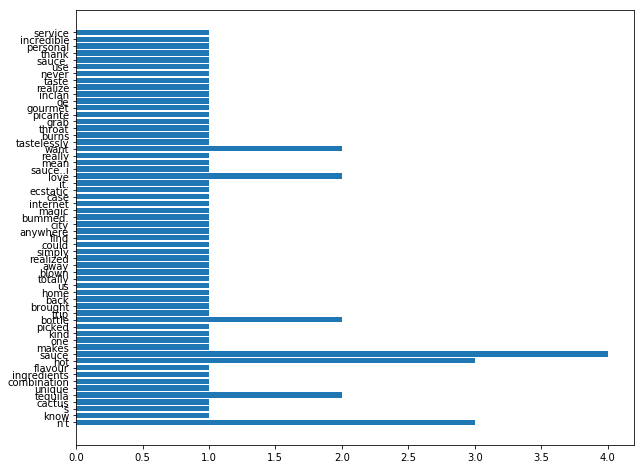

In [0]:
# Set up FreqDist()
from nltk import FreqDist

freqdist = FreqDist(clean_tokens)
plt.figure(figsize=(10,8))
plt.barh(y=[key for key in freqdist.keys()], 
         width=[val for val in freqdist.values()]);

Since this is just one review, the frequency distribution is not very informative, but it will make more sense when we pass it a large number of texts.

Now let's see what a lemmatizer can do for this sample text.

In [0]:
# Set up lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()
lemmata = []
for word in clean_tokens:
    lemmata.append(lem.lemmatize(word))
lemmata[:10]

["n't",
 'know',
 "'s",
 'cactus',
 'tequila',
 'unique',
 'combination',
 'ingredient',
 'flavour',
 'hot']

Note that the lemmatizer has changed "ingredients" to "ingredient." Lemmatizing helps make frequency distributions more meaningful by combining different forms of the same word into one form.

### Analyze the "helpful" reviews

Next I want to look at all the "helpful" reviews together to learn more about their vocabulary. I'll start by extracting and combining all the review texts, then tokenizing, lemmatizing, and calculating the frequency distribution. Then I'll plot this so I can visually inspect the most common words in "helpful" reviews.

In [0]:
# Get all helpful reviews
helpful = data_clean[data_clean.helpful > 0]
combined_text = ''
for row in helpful.index:
    combined_text += helpful.loc[row, 'text']

In [0]:
# Tokenize
tokens = word_tokenize(combined_text)

In [0]:
# Convert all tokens to lowercase
lower_tokens = [word.lower() for word in tokens if word.lower() not in stop_list]

In [0]:
# Lemmatize
lemma_tokens = [lem.lemmatize(word) for word in lower_tokens]

In [0]:
# Get frequency distribution
freqdist = FreqDist(lemma_tokens)

In [0]:
# Select top 50 words
top_50 = freqdist.most_common(50)

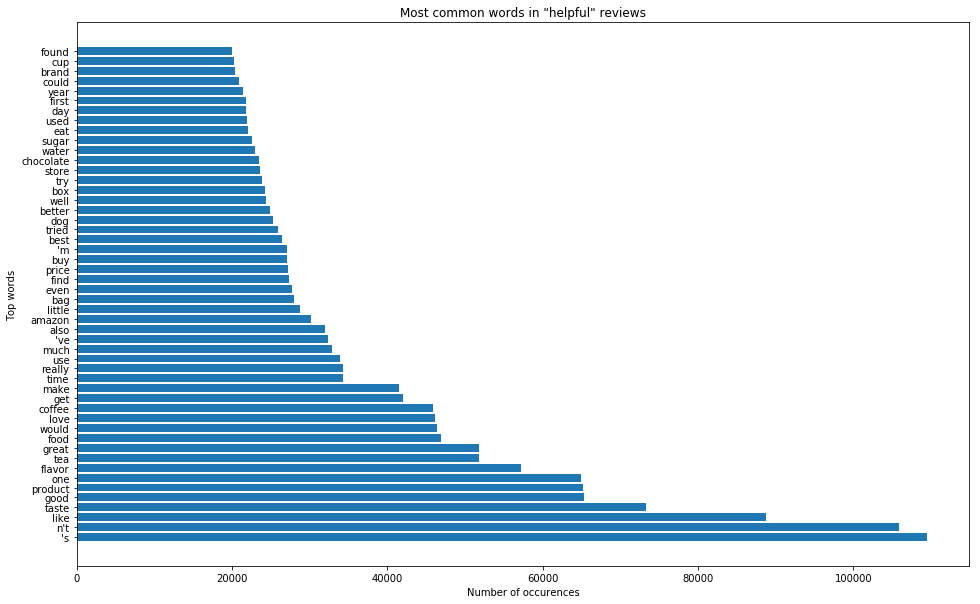

In [0]:
# Plot top 50 words
plt.figure(figsize=(16,10))
plt.barh(y=[x[0] for x in top_50], width=[x[1] for x in top_50])
plt.xlabel('Number of occurences')
plt.ylabel('Top words')
plt.title('Most common words in "helpful" reviews')
plt.show();

Because the lemmatizer I used separates the suffixes from contractions and possessives and treats them as distinct words, the top words in this plot are really just parts of words. Ignoring those, we can see make the following observations about the "helpful" reviews:

- The top types of foods mentioned are tea, coffee, chocolate, water, sugar, and dog (food).
- There are several words expressing positive emotion (like, love, good, great) and no obvious expressions of negative emotion (hate, bad, etc.). Keep in mind, however, that negative emotion could be expressed through negation of a positive term ("It wasn't good," I didn't like it," etc.).
- There are references to packaging, serving, or portioning (cup, bag, box).
- "Price" is obviously discussed pretty frequently.

#### Look at bigrams

By grouping the text into adjacent pairs of words and then examining the most common pairs, I hope to learn more about the important concepts in the helpful reviews.

In [0]:
# Find the top 50 bigrams
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder.from_words(lemma_tokens)

scored = finder.score_ngrams(bigram_measures.raw_freq)

scored[:50]

[(('ca', "n't"), 0.00152568357473086),
 (('taste', 'like'), 0.001025859242584942),
 (('wo', "n't"), 0.0007550925729135553),
 (('grocery', 'store'), 0.0007136114837888143),
 (('href=', 'http'), 0.0006616461633468311),
 (('green', 'tea'), 0.0005728720742584429),
 (("'ve", 'tried'), 0.000554752587525383),
 (('highly', 'recommend'), 0.0005403937489822033),
 (('peanut', 'butter'), 0.0005251232381505679),
 (('could', "n't"), 0.000507117710453565),
 (('taste', 'good'), 0.0004998243321459181),
 (("n't", 'like'), 0.0004817048454128582),
 (('taste', 'great'), 0.00047703252493452197),
 (("n't", 'know'), 0.0004758929345739522),
 (('much', 'better'), 0.00047008102373504617),
 (('dog', 'food'), 0.0004442123225501115),
 (('gluten', 'free'), 0.0004381724936390915),
 (('would', "n't"), 0.0004368049852064077),
 (("n't", 'get'), 0.0003870048864495071),
 (('really', 'good'), 0.00034438420696419626),
 (('olive', 'oil'), 0.0003440423298560253),
 (('year', 'old'), 0.00033583727925992266),
 (('really', 'like'

The most frequent bigrams highlight a few key themes of the "helpful" reviews:

- Sentiment seems to skew positive ("great product," "would recommend," "taste great," etc.)
- Frequently mentioned foods include "dark chocolate," "coconut oil," "green tea," "peanut butter," and pet foods.
- The appearance of "gluten free" on the list highlights the importance of a particular dietary concern
- Another interesting theme is the difficulty of finding a product locally ("[ca]n't find", "hard [to] find," "grocery store," "local store"). This is a key part of Amazon's value proposition: because they carry such a wide variety of products, consumers can turn to them for items that are hard to find locally.

There is another way to determine which bigrams are most important: the mutual information score. This metric reflects how much each member of a pair of words can tell us about the other member of the pair. For instance, we can understand what "cup" is without "coffee," since there are lots of contexts in which we use the word "cup," but "pong" doesn't make as much sense outside of the phrase "ping pong." 

Let's check that out below.

In [0]:
# Get mutual information scores
pmi_finder = nltk.collocations.BigramCollocationFinder.from_words(lemma_tokens)

pmi_finder.apply_freq_filter(5)

pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)

pmi_scored[:50]

[(('vergnano', '1882'), 20.743053245793853),
 (('algernon', 'freeman-mitford'), 20.48001883996006),
 (('ping', 'pong'), 20.257626418623612),
 (('riso', 'bello'), 20.257626418623612),
 (('bbp', 'okc'), 20.25762641862361),
 (('dentie', 'toothpowder'), 20.25762641862361),
 (('dunaliella', 'salina'), 20.25762641862361),
 (('saf®', 'bakipan®'), 20.25762641862361),
 (('vialone', 'nano'), 20.216984434126264),
 (('192f', '204'), 20.064981340681214),
 (('cucina', 'antica'), 20.064981340681214),
 (('j.j.', 'gottenbos'), 20.064981340681214),
 (('nagasaki', 'jjamppong'), 20.064981340681214),
 (('r.k.', 'downey'), 20.064981340681214),
 (('r.o', 'vles'), 20.064981340681214),
 (('robblen', 'r.k.'), 20.064981340681214),
 (('vles', 'j.j.'), 20.064981340681214),
 (('y.', 'golovko'), 20.064981340681214),
 (('fischer', 'wieser'), 20.06498134068121),
 (('star®', 'saf®'), 20.06498134068121),
 (('lymph', 'node'), 20.035233997287165),
 (('insightful', 'inspirational'), 19.994592012789816),
 (('//www.amazon.co

Unfortunately, most of the bigrams in this list are brand names, which are not very important for this analysis. 

Let's try again below with trigrams.

#### Look at trigrams

Looking at slightly longer phrases may give us a different perspective on important concepts in the reviews. Let's try trigrams.

In [0]:
# View top trigrams by raw frequency
trigram_measures = nltk.collocations.TrigramAssocMeasures()

tri_finder = nltk.collocations.TrigramCollocationFinder.from_words(lemma_tokens)

tri_scored = tri_finder.score_ngrams(trigram_measures.raw_freq)

tri_scored[:50]

[(('local', 'grocery', 'store'), 0.00016672206975136303),
 (('ca', "n't", 'find'), 0.00011407299509303787),
 (('health', 'food', 'store'), 0.00010461439510030845),
 (('ca', "n't", 'get'), 0.00010438647702819449),
 (("'s", 'red', 'mill'), 9.469995896335112e-05),
 (('could', "n't", 'find'), 9.196494209798357e-05),
 (('bob', "'s", 'red'), 9.093931077347075e-05),
 (('ca', "n't", 'wait'), 9.059743366529981e-05),
 (('high', 'fructose', 'corn'), 8.854617101627414e-05),
 (('ca', "n't", 'beat'), 8.809033487204622e-05),
 (('fructose', 'corn', 'syrup'), 8.444364571822283e-05),
 (("n't", 'taste', 'like'), 7.45292095812655e-05),
 (('ca', "n't", 'say'), 7.247794693223985e-05),
 (('would', 'highly', 'recommend'), 7.099647946349909e-05),
 (('go', 'long', 'way'), 7.008480717504325e-05),
 (('/a', 'href=', 'http'), 6.928709392264438e-05),
 (('trader', 'joe', "'s"), 6.86033397063025e-05),
 (('pack', '6', '/a'), 6.495665055247911e-05),
 (('ca', "n't", 'go'), 6.484269151642213e-05),
 (('pack', '12', '/a'), 

There's a lot going on here!

- Again we can see a big emphasis on what folks couldn't find at their local store, plus a telling reference to "Amazon's price."
- Trader Joe's and Bob's Red Mill are frequently mentioned by name.
- There are plenty of positive sentiments ("would definitely recommend," "would highly recommend," etc.).
- Of all the qualities a product can have, taste seems to be the most important.
- High fructose corn syrup seems to be a major concern.

In [0]:
# View top trigrams by mutual information score
tri_pmi_finder = nltk.collocations.TrigramCollocationFinder.from_words(lemma_tokens)

tri_pmi_finder.apply_freq_filter(5)

tri_pmi_scored = tri_pmi_finder.score_ngrams(trigram_measures.pmi)

tri_pmi_scored[:50]

[(('tovolo', 'teeli', 'frieling/swissgold'), 40.37507517919895),
 (('star®', 'saf®', 'bakipan®'), 40.322607759304816),
 (('r.o', 'vles', 'j.j.'), 40.12996268136243),
 (('robblen', 'r.k.', 'downey'), 40.12996268136243),
 (('vles', 'j.j.', 'gottenbos'), 40.12996268136243),
 (('readable', 'insightful', 'inspirational'), 40.05957335347102),
 (('//www.amazon.com/gp/product/b0012s1v2a', 'oster', '5965'),
  39.73764525858367),
 (('mikhail', 'y.', 'golovko'), 39.67053106272513),
 (('5965', 'stainless-steel', '1-1/2-liter'), 39.28196577480747),
 (('h.m.s', 'peregrine', 'cavendish'), 38.466048839246454),
 (('oster', '5965', 'stainless-steel'), 38.05957335347102),
 (('sir', 'algernon', 'freeman-mitford'), 38.0531470843116),
 (('y.', 'golovko', 'eric'), 37.96003767992011),
 (('dunaliella', 'salina', 'algae'), 37.930290336526056),
 (('downey', 'a.', 'ashri'), 37.70369792666033),
 (('r.k.', 'downey', 'a.'), 37.70369792666033),
 (('nutr', '1982', 'apr'), 37.67463546105787),
 (('192f', '204', 'f.'), 3

And once again, ranking the trigrams by mutual information score doesn't give us much insight we could act on.

### Analyze the "unhelpful" reviews

I've already seen that there is no correlation between "helpfulness" and a review's other non-textual attributes, so I suspect that the texts of helpful and non-helpful reviews may be pretty similar as well. 

Let's do the same analysis as above, but this time for the reviews that received no "helpful" votes. Remember, this doesn't necessarily mean that the review was positively <em>unhelpful</em>, just that no one was motivated to mark it as "helpful."

In [0]:
# Get all unhelpful reviews
unhelpful = data_clean[data_clean.helpful == 0]
combined_text_unhelpful = ''
for row in unhelpful.index:
    combined_text_unhelpful += unhelpful.loc[row, 'text']

In [0]:
# Tokenize
tokens_unhelpful = word_tokenize(combined_text_unhelpful)

In [0]:
# Convert all tokens to lowercase
lower_tokens_unhelpful = [word.lower() for word in tokens_unhelpful if word.lower() not in stop_list]

In [0]:
# Lemmatize
lemma_tokens_unhelpful = [lem.lemmatize(word) for word in lower_tokens_unhelpful]

In [0]:
# Get frequency distribution
freqdist_unhelpful = FreqDist(lemma_tokens_unhelpful)

In [0]:
# Select top 50 words
top_50_unhelpful = freqdist_unhelpful.most_common(50)

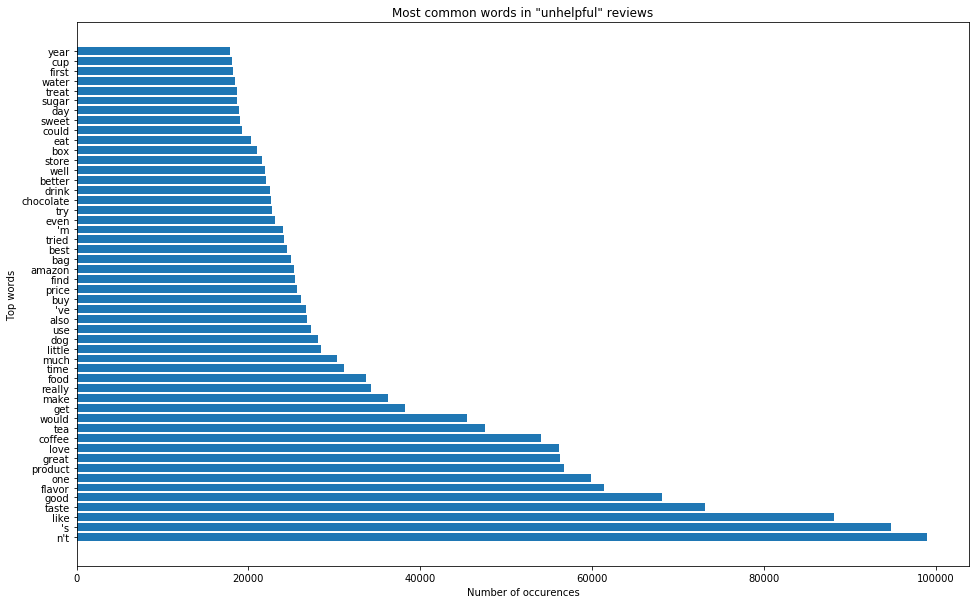

In [0]:
# Plot top 50 words
plt.figure(figsize=(16,10))
plt.barh(y=[x[0] for x in top_50_unhelpful], 
         width=[x[1] for x in top_50_unhelpful])
plt.xlabel('Number of occurences')
plt.ylabel('Top words')
plt.title('Most common words in "unhelpful" reviews')
plt.show();

This list of top 50 words looks pretty similar to the one above. We see "like," "love," "good," and "great" near the top. Coffee, tea, chocolate, water, sugar, and dog food are listed. "Time," "price," and "Amazon" are there, as well as "bag," "box," and "cup." Just comparing the two frequency distributions visually, I can't detect any major difference that would make "helpful" and "unhelpful" reviews easy to distinguish.

Let's look at some summary visualizations of the "helpful" and "unhelpful" reviews.

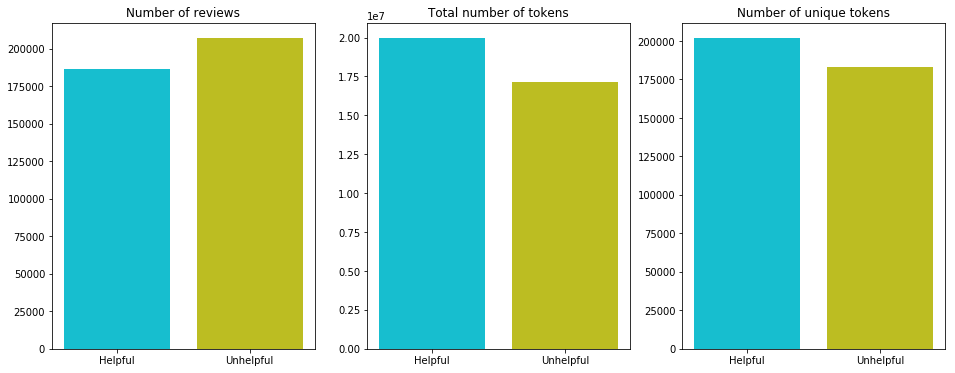

In [0]:
# Compare helpful and unhelpful review data subsets
fig, axes = plt.subplots(1, 3, figsize=(16,6))

ax1 = axes[0]
ax1.bar(x=['Helpful', 'Unhelpful'], height=[len(helpful), len(unhelpful)], 
        color=['tab:cyan', 'tab:olive'])
ax1.set_title('Number of reviews')

ax2 = axes[1]
ax2.bar(x=['Helpful', 'Unhelpful'], height=[len(tokens), len(tokens_unhelpful)],
        color=['tab:cyan', 'tab:olive'])
ax2.set_title('Total number of tokens')

ax3 = axes[2]
ax3.bar(x=['Helpful', 'Unhelpful'], height=[len(freqdist), len(freqdist_unhelpful)],
        color=['tab:cyan', 'tab:olive'])
ax3.set_title('Number of unique tokens')

plt.show();

Although the "helpful" reviews have a slightly larger vocabulary, the two subsets are still very similar.

### Visualize "helpful" and "unhelpful" reviews using t-SNE

A t-SNE plot visualizes observations by reducing all their features to just two or three and plotting them in a 2D or 3D space. Different classes or clusters can then be examined in terms of their spatial relationships to one another. I'll create a t-SNE plot using the review texts as data to help me understand how much overlap there is between the two classes in this dataset.

In [0]:
# Create a sample of 3000 reviews and their labels
data_tsne = pd.read_csv('data_clean.csv')
data_tsne.drop('Unnamed: 0', axis=1, inplace=True)
data_tsne['helpful_1'] = np.where(data_tsne['helpful'] > 0, 1, 0)
data_brief = data_tsne.sample(3000)
data_brief.helpful_1.value_counts()

0    1605
1    1395
Name: helpful_1, dtype: int64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


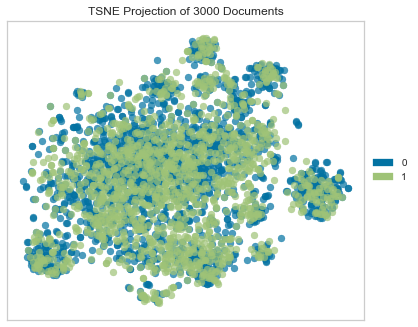

In [0]:
# Import needed packages
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer

# Prepare the data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data_brief.text)
y = data_brief.helpful_1

# Plot t-SNE
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show();

The two classes almost perfectly overlap! This confirms what I surmised above: we have a machine learning problem on our hands. I would not be able to distinguish a helpful from an unhelpful review by vocabulary alone. Let's see if a neural network can do it.

# Predicting "helpfulness"

Here my goal is to build a model that can predict whether a review is "helpful" or not using only the text itself. I will try both Random Forests and a few different neural networks, and I'm especially interested in determining which preprocessing techniques are most useful when working with texts like these.

Here's a rundown of the preprocessing techniques and models you'll see below:
- Bigrams with Random Forest
- Term-Document Matrix with Random Forest
- TF-IDF with Random Forest
- GloVe embeddings with Random Forest
- Keras Embedding layer with LSTM
- <span style="background-color:red">Word2Vec embeddings ???</span>


## Reload and split the data

To save me (or anyone else running this notebook) the trouble of running all the cells above, here is a shortcut for getting just the review texts and the `HelpfulnessNumerator` column in their own DataFrame.

In [0]:
# Load the first packages we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
# Read in the text and target dataset from local copy
data_clean = pd.read_csv('data_clean.csv')

In [3]:
# Alternatively, read in the text and target dataset from Google Drive
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read in dataset from Drive
data_clean = pd.read_csv("/content/drive/My Drive/helpful-reviews/data_clean.csv")
data_clean.drop('Unnamed: 0', axis=1, inplace=True)

I am aiming to predict whether a review was helpful or not, so I'm going to treat this as a binary classification problem. I will create a new boolean column that contains 1 if a review received 1 or more "helpful" votes, or 0 if no one ever voted the review "helpful."

In [5]:
# Create boolean column `helpful_1`
data_clean['helpful_1'] = np.where(data_clean['helpful'] > 0, 1, 0)
data_clean.head()

,helpful,text,helpful_1
0,1,I have bought several of the Vitality canned d...,1
1,0,Product arrived labeled as Jumbo Salted Peanut...,0
2,1,This is a confection that has been around a fe...,1
3,3,If you are looking for the secret ingredient i...,1
4,0,Great taffy at a great price. There was a wid...,0


I'd like to do a quick check to see how big my two classes are; if they are very unequal in size, I may need to balance them so that I trust accuracy as an evaluation metric.

In [6]:
# Calculate percent of "helpful" v. "unhelpful" reviews
data_clean.helpful_1.value_counts(normalize=True)

0    0.526263
1    0.473737
Name: helpful_1, dtype: float64

Although the classes aren't perfectly equal, I think they are close enough. I don't have to worry about my model scoring highly on accuracy just by predicting the same class over and over. 

Now I need to split the data into training, validation, and test sets. Because the dataset is so large, I'm going to use 80% of it for training and 10% each for validation and testing.

In [6]:
all_length = len(data_clean)
train_len = round(0.8 * all_length)
val_len = round(0.1 * all_length)

print('Train set length:', train_len)
print('Validation set length:', val_len)

Train set length: 314863
Validation set length: 39358


In [0]:
# Train-val-test split
from sklearn.model_selection import train_test_split

y = data_clean['helpful_1']
X = data_clean['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_len,
                                                    random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                test_size=val_len,
                                                random_state=123)

In [9]:
# Check that classes are roughly equally represented in each set
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.52559
1    0.47441
Name: helpful_1, dtype: float64
0    0.529219
1    0.470781
Name: helpful_1, dtype: float64
0    0.528685
1    0.471315
Name: helpful_1, dtype: float64


I now have my training, validation, and test sets, and the two classes are represented roughly equally in all three.

For convenience, here is the code to create my list of stopwords again:

In [8]:
# Set up stopwords to be removed
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's proceed to the first model.

## Random Forests

The first type of model I'd like to test is a Random Forest, since they tend to do well with classification problems, even ones with pretty complex input data like I have here. I'm not sure which preprocessing technique will yield the best results, so I'll try a few (bigrams, term-document matrix, TF-IDF) and then tune a model with whichever seems to work the best.

### Train a Random Forest model on bigrams

Bigrams are pairs of adjacent words in a text. For this test, I'm going to use `sklearn`'s `CountVectorizer()` and specify that it should create bigrams and then calculate count-based vectors for them. These vectors record how many times each bigram occurs in each text in the corpus. The `CountVectorizer()` will also remove the same list of stopwords that I developed above, and it will stop after identifying 100 bigrams (that's a number I may want to adjust later on).

In [0]:
# Fit a CountVectorizer-RandomForest pipeline (~ 3.5 min.)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe_bigram_rf = Pipeline([('vectorizer', CountVectorizer(analyzer='word', 
                                                          ngram_range=(2, 2), 
                                                          stop_words=stop_list, 
                                                          max_features=100)),
                        ('forest', RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1))])

pipe_bigram_rf.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(2, 2),
                                 preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                  

In [0]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = pipe_bigram_rf.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_train))

Training accuracy: 0.592232177169118


That's a pretty low training accuracy score! It's likely that 100 bigrams are not enough to really describe this corpus. 

Let's take a look at how the classifier performs on the validation set.

In [0]:
# Validate
y_pred_val = pipe_bigram_rf.predict(X_val)
print('Validation accuracy:', accuracy_score(y_val, y_pred_val))

Validation accuracy: 0.5378830225113065


In [0]:
# View additional metrics
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.54      0.84      0.66     20829
           1       0.52      0.20      0.29     18529

    accuracy                           0.54     39358
   macro avg       0.53      0.52      0.47     39358
weighted avg       0.53      0.54      0.48     39358



While recall is fairly high when predicting class 0 (unhelpful), it is very low when predicting class 1 (helpful). Precision is middling for both classes. 

Let's see if another preprocessing technique can do better.

### Train a Random Forest model on a term-document matrix

A term-document matrix records how many times each word in a corpus occurs in each document. Again I'll use `CountVectorizer()` to calculate this matrix. It will also remove stopwords and limit itself to 100 features (words).

In [0]:
# Tokenize + lower case (~ 30 min.)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe_tdm_rf = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list, 
                                                       max_features=100)),
                        ('forest', RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1))])

pipe_tdm_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(1, 1),
                                 preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                  

In [0]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = pipe_tdm_rf.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Training accuracy: 0.9723625830916939
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    165489
           1       0.98      0.96      0.97    149374

    accuracy                           0.97    314863
   macro avg       0.97      0.97      0.97    314863
weighted avg       0.97      0.97      0.97    314863



Wow! That is some extremely high training accuracy. I'm concerned the model may be overfit to the training data.

Let's predict on the validation set.

In [0]:
# Validate
y_pred_val = pipe_tdm_rf.predict(X_val)
print('Validation accuracy:', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Validation accuracy: 0.5460389247421109
              precision    recall  f1-score   support

           0       0.56      0.62      0.59     20829
           1       0.52      0.46      0.49     18529

    accuracy                           0.55     39358
   macro avg       0.54      0.54      0.54     39358
weighted avg       0.54      0.55      0.54     39358



This model performed a tiny bit better in validation than the one that took in bigrams.. The term-document matrix contains columns for only 100 words, and those words may be far better represented in the training set than in the validation set. For instance, the training set could contain lots of reviews about coffee and tea, and by chance the pet food reviews could have ended up in the validation set. Making a bigger matrix could improve things, but for now, let's take a look at another preprocessing technique.

### Train a Random Forest model on TF-IDF values

Term frequency-inverse document frequency (TF-IDF) values are another way to quantify how often a word occurs in a text. Unlike other forms of count vectorization, this method places more emphasis on rare words, since these are more likely to provide salient information about the specific subject matter or style of a text. I'll use the dedicated `TfidfVectorizer()` contained in `sklearn.feature_extraction.text`, remove stopwords, and limit the results to 100 features as before.

In [0]:
# Build a pipeline for TF-IDF vectorization and classification (~ 26.5 min.)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe_tfidf_rf = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stop_list, 
                                                         max_features=100)),
                          ('forest', RandomForestClassifier(n_estimators=100,
                                                            n_jobs=-1))])

pipe_tfidf_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=100,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves',...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impu

In [0]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = pipe_tfidf_rf.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Training accuracy: 0.9720989763802035
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    165489
           1       0.98      0.96      0.97    149374

    accuracy                           0.97    314863
   macro avg       0.97      0.97      0.97    314863
weighted avg       0.97      0.97      0.97    314863



Once again, it looks like the model may be overfit to the training data. 

Let's check performance on the validation set.

In [0]:
# Validate
y_pred_val = pipe_tfidf_rf.predict(X_val)
print('Validation accuracy:', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Validation accuracy: 0.5515778240764266
              precision    recall  f1-score   support

           0       0.57      0.65      0.60     20829
           1       0.53      0.44      0.48     18529

    accuracy                           0.55     39358
   macro avg       0.55      0.55      0.54     39358
weighted avg       0.55      0.55      0.55     39358



What I've learned from these models so far is that TDM and TF-IDF can both produce models with some predictive power, although they are both overfit. Bigrams didn't do so well. All three were tested with a `max_features` of 100 to keep running times low. Starting from TDM or TF-IDF, a Random Forest could be tuned or other classifiers could be tried in the hope of getting better results.

### Tune the best Random Forest model using grid search

Since the model trained on TF-IDF values performed marginally better than the other two, I'll work on tuning it to see if performance will improve. 

#### Grid search for `n_estimators`, `max_depth`

First I'll try to tune the model using a grid search to find the optimal values for `n_estimators` and `max_depth`, keeping the size of the input vectors the same as before.

In [0]:
# Vectorize the training samples
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words=stop_list, max_features=100)
train_tfidf = tfidf_vec.fit_transform(X_train)

In [16]:
# Use GridSearchCV to find optimal number of estimators (~ 2.25 hrs.)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [10, 100, 1000],
          'max_depth': [None, 25],
          'n_jobs': [-1]}
rf = RandomForestClassifier()

grid_tfidf_rf = GridSearchCV(rf, params, cv=2, n_jobs=-1, verbose=1)

grid_tfidf_rf.fit(train_tfidf, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 114.1min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [17]:
# View results
print('Best score:', grid_tfidf_rf.best_score_)
print('Best params:', grid_tfidf_rf.best_params_)

Best score: 0.5668147768345564
Best params: {'max_depth': 25, 'n_estimators': 1000, 'n_jobs': -1}


In [0]:
# Pickle the model
import pickle
with open('/content/drive/My Drive/helpful-reviews/best_rf.pickle', 'wb') as f:
    pickle.dump(grid_tfidf_rf, f, pickle.HIGHEST_PROTOCOL)

#### Vectorize with 200 features

In [0]:
# Try making bigger embeddings
tfidf_vec_bigger = TfidfVectorizer(stop_words=stop_list, max_features=200)
train_tfidf_bigger = tfidf_vec_bigger.fit_transform(X_train)

Raising the number of features from 100 to 200 could lead to overfitting, or it could be adding features that aren't very useful for prediction. I'll use `TruncatedSVD()` (a form of Principal Components Analysis for sparse matrices) to determine how many of those 200 features I really need to explain 80% or more of the variance in the data.

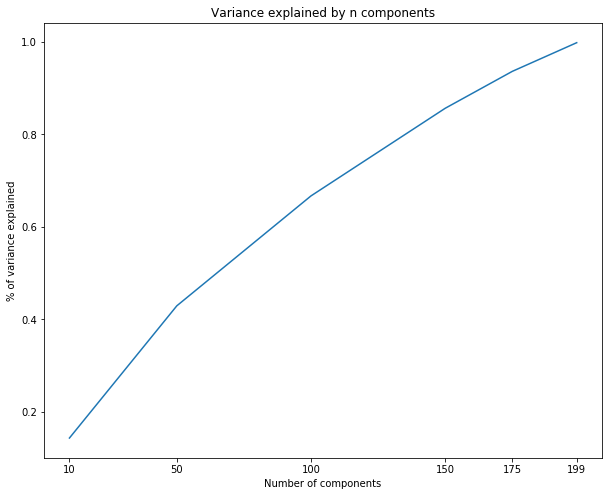

In [21]:
# Import TruncatedSVD (~ 4 min.)
from sklearn.decomposition import TruncatedSVD

# Try several numbers of components to explain 80% of variance
comps = [10, 50, 100, 150, 175, 199]
var_sums = []
for comp in comps:
    svd = TruncatedSVD(n_components=comp, n_iter=10, random_state=42)
    svd.fit(train_tfidf_bigger)
    var_sums.append(np.sum(svd.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 50, 100, 150, 175, 199])
plt.show();


In the plot above, I can see that using 150 out of 200 components would allow me to explain over 80% of the variance. I'll now build and fit a pipeline for a Random Forest model using the hyperparameters selected above and 150 components generated from TF-IDF vectors of length 200.

In [24]:
# Build and fit pipeline for Random Forest with 150 TF-IDF components (~ 40 min.)
from sklearn.pipeline import Pipeline
pipe_tfidf_svd_rf = Pipeline([
    ('tf_idf', TfidfVectorizer(stop_words=stop_list, max_features=200)),
    ('components', TruncatedSVD(n_components=150, n_iter=7, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=25, n_jobs=-1))])

pipe_tfidf_svd_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=200,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                

In [0]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = pipe_tfidf_svd_rf.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Training accuracy: 0.9948136173510383
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    166082
           1       0.99      1.00      0.99    148781

    accuracy                           0.99    314863
   macro avg       0.99      0.99      0.99    314863
weighted avg       0.99      0.99      0.99    314863



In [0]:
# Validate
y_pred_val = pipe_tfidf_svd_rf.predict(X_val)
print('Training accuracy:', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Training accuracy: 0.5734031200772397
              precision    recall  f1-score   support

           0       0.75      0.57      0.65     27076
           1       0.38      0.57      0.46     12282

    accuracy                           0.57     39358
   macro avg       0.56      0.57      0.55     39358
weighted avg       0.63      0.57      0.59     39358



In [0]:
# Pickle the model
import pickle
with open('/content/drive/My Drive/helpful-reviews/best_rf_150_comp.pickle', 'wb') as f:
    pickle.dump(pipe_tfidf_svd_rf, f, pickle.HIGHEST_PROTOCOL)

Through this tuning process, validation accuracy hasn't really improved. Once again the model appears to be overfit to the training data, but I expect that this is because the 200 features generated by TF-IDF will obviously be more tailored to the training than the validation data. I could try even bigger embeddings, but given how long the models are taking to run, I'll stop here and explore some other options.

## GloVe embeddings

Another important strategy when preprocessing text for prediction is to embeddings, or vectors representing each word that were created by training a model beforehand. This is a form of transfer learning. We have the option to create our own embeddings or use ones that someone else created by training a model on some other dataset. 

In this section I'll use [GloVe embeddings](https://nlp.stanford.edu/projects/glove/), which were created by training a model on massive amounts of text on the web (think all of Wikipedia). I'll get the GloVe embeddings for each word in my corpus, and then pass those to various models to see how they perform.

### Get GloVe embeddings

First I need to join up all my reviews into one massive text and find the set of unique words in my corpus.

In [9]:
# Get total vocabulary
from keras.preprocessing.text import text_to_word_sequence

all_train_text = ''
for row in X_train.index:
    all_train_text += X_train[row]
total_vocab = text_to_word_sequence(all_train_text, 
                                    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                    lower=True, split=' ')
total_vocab = set(total_vocab)

Using TensorFlow backend.


I downloaded a smallish set of GloVe embeddings to my Google Drive, and here I will extract the relevant vector for each word in `total_vocab`. If you want to run this cell yourself, you'll need to [download your own copy of the GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and change the filepath below to the correct one for your environment.

In [0]:
# Get GloVe embeddings for words in total_vocab
glove = {}
with open('/content/drive/My Drive/helpful-reviews/glove.6B.50d.txt') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

I now have a dictionary containing the GloVe embedding vector for each word in my corpus.

Let's take a look at one of them. 

In [11]:
# View a sample embedding
glove['coffee']

array([-0.54015 , -0.29931 , -0.67591 ,  0.15784 ,  0.90241 , -0.89567 ,
       -1.1267  , -0.69013 ,  0.7116  ,  0.71231 ,  0.11031 , -0.37268 ,
        0.93846 , -0.42899 ,  1.0807  ,  0.43785 , -0.38785 ,  0.65528 ,
        0.34501 , -1.3793  ,  1.114   , -0.20227 ,  0.53612 ,  0.67394 ,
       -0.52717 , -0.30703 , -0.14833 ,  0.78579 ,  0.84364 ,  0.56468 ,
        2.1954  , -0.097544, -0.41744 ,  1.0296  ,  0.083024, -0.1552  ,
       -1.1257  ,  0.74416 ,  1.1534  ,  0.24415 ,  0.057113,  0.63826 ,
       -0.35989 , -0.031659,  0.88827 ,  0.78731 , -0.47028 , -0.69737 ,
        0.12029 , -0.41486 ], dtype=float32)

To make these new embeddings easier to use, I'm going to create a class that will take all the word vectors for a given review and average them to create a vector representation of that review. This class can then be used in pipelines to prepare reviews to be passed to a classifier.

In [0]:
# Create gloVe vectorizer class
class GloVecto(object):
    def __init__(self, vec):
        self.vec = vec
        if len(vec) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(vec[next(iter(glove))])
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] 
                                 or [np.zeros(self.dimensions)], 
                                 axis=0) for words in X])

### Train various baseline models using GloVe embeddings

I know that I'll want to try out my GloVe embeddings in a Random Forest model for comparison to the others above, but I also want to see how they do in a few other types of models. 

I'll instantiate a baseline Random Forest, a logistic regression model, and a Support Vector Classifier, and feed each my GloVe embeddings. Then I'll use cross-validation to score each model and find the best one. Given the long runtimes I'm expecting, I'll only do 2-fold cross-validation.

In [0]:
# Set up several classifiers with GloVe for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([("GLoVe Vectorizer", GloVecto(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, 
                                                       verbose=True))])

lr = Pipeline([("GLoVe Vectorizer", GloVecto(glove)),
               ('Scaler', StandardScaler()),
               ('Logistic Regression', LogisticRegression())])

svc = Pipeline([("GLoVe Vectorizer", GloVecto(glove)),
                ('Scaler', StandardScaler()),
                ('Support Vector Machine', SVC())])


models = [('Random Forest', rf),
          ("Logistic Regression", lr),
          ("Support Vector Machine", svc)]

In [30]:
# Calculate and view model scores
# Runtimes: rf ~ 6 min., lr ~ 6 min., svc ~ 3.5 hrs.
scores = ([(name, cross_val_score(model, X_train, y_train, cv=2).mean()) 
            for name, model, in models])
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

[('Random Forest', 0.5452180793527439),
 ('Logistic Regression', 0.5349151825660785),
 ('Support Vector Machine', 0.5610598876384995)]

The Support Vector Machine did a tiny bit better than the other two, but with my computing setup, I know it will take much longer to train. I can also see that the logistic regression had some convergence issues. For these reasons, I'd like to invest a little more effort in tuning that Random Forest to see if better hyperparameters can raise validation accuracy by 1 percentage point or more.

### Tune Random Forest with GloVe embeddings

I've seen that a Random Forest can do slightly better than random guessing when given GloVe embeddings. Now I'll examine that model in greater detail and then try tuning it to improve performance.

In [0]:
# Prep data for feeding to Random Forest
glover = GloVecto(glove)
glover.fit(X_train, y_train)
X_train_glove = glover.transform(X_train)

In [55]:
# Use GridSearchCV to find optimal number of estimators (~ 1.25 hrs.)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [10, 100, 1000],
          'max_depth': [None, 25],
          'n_jobs': [-1]}
rf = RandomForestClassifier()

grid_glove_rf = GridSearchCV(rf, params, cv=2, n_jobs=-1, verbose=1)

grid_glove_rf.fit(X_train_glove, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 53.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [56]:
# View results
print('Best score:', grid_glove_rf.best_score_)
print('Best params:', grid_glove_rf.best_params_)

Best score: 0.557147076922881
Best params: {'max_depth': 25, 'n_estimators': 1000, 'n_jobs': -1}


In [0]:
# Pickle the model
import pickle
with open('/content/drive/My Drive/helpful-reviews/best_glove_rf.pickle', 'wb') as f:
    pickle.dump(grid_glove_rf, f, pickle.HIGHEST_PROTOCOL)

In [0]:
X_val_glove = glover.transform(X_val)

In [59]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = grid_glove_rf.predict(X_train_glove)
print('Training accuracy:', accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Training accuracy: 0.9638477687121065
              precision    recall  f1-score   support

           0       1.00      0.94      0.96    165489
           1       0.93      1.00      0.96    149374

    accuracy                           0.96    314863
   macro avg       0.96      0.97      0.96    314863
weighted avg       0.97      0.96      0.96    314863



In [60]:
# Validate
y_pred_val = grid_glove_rf.predict(X_val_glove)
print('Validation accuracy:', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Validation accuracy: 0.5611311550383657
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     20829
           1       0.55      0.40      0.46     18529

    accuracy                           0.56     39358
   macro avg       0.56      0.55      0.54     39358
weighted avg       0.56      0.56      0.55     39358



Validation accuracy has increased by a whole percentage point, and I'm also pleased to see that training accuracy has gone down a little. All the same, I would like to do better than 56% accuracy, so next I'll try a much more complex model: a recurrent neural network.

## Neural Networks

Using Keras, it's possible to build a neural network that will calculate its own embeddings on the fly. This approach can perform better than the transfer learning approach above because the embeddings will be based on how words are used in this specific dataset. By contrast, GloVe embeddings are calculated based on how words were used in a training dataset not related to my dataset, so the values may not be as meaningful in my context.

In this section I will build and train a series of Long Short-Term Memory networks, a type of recurrent neural network, to classify reviews using embeddings calculated on the fly. 

### Train LSTM with embedding layer

In [0]:
# Import needed packages/classes
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
import tensorflow as tf

The next step is an important one: I'm going to take each review, turn it into a vector of tokens, and then ensure that all reviews have vectors of the same length by padding any short vectors with zeros and trimming any long vectors down to size. In the end, each review will be represented by a vector of length 100. I'm doing this for the training, validation, and test sets so they'll be ready for comparison later on.

In [0]:
# Create sequences of tokens uniform in length for all reviews (~ 1 min.)
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=100)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=100)

X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=100)

Next I build the neural network itself. This will be a recurrent neural network using Long-Short Term Memory cells (LSTMs). 

The Embedding layer will be creating vectors of length 128 for 20,000 words from the vocabulary in the training set. It will them pass these embeddings through two layers of LSTMs, then condense those outputs for feeding into two Dense layers. Finally, a single-node Dense layer will make a prediction of "helpful" or "unhelpful" for each review.

In [18]:
# Build and train neural network
checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/helpful-reviews/lstm_model_1.h5', 
                                       save_best_only=True)

embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(20000, embedding_size, input_shape=(100,)))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_tok_pad, y_train, epochs=5, batch_size=1024, 
                    validation_data=(X_val_tok_pad, y_val),
                    callbacks=[checkpoint])

Train on 314863 samples, validate on 39358 samples
Epoch 1/5
314863/314863 [==============================] - 82s 260us/sample - loss: 0.8191 - acc: 0.5212 - val_loss: 0.6805 - val_acc: 0.5582
Epoch 2/5
314863/314863 [==============================] - 80s 255us/sample - loss: 0.7040 - acc: 0.5498 - val_loss: 0.6754 - val_acc: 0.5740
Epoch 3/5
314863/314863 [==============================] - 80s 254us/sample - loss: 0.6961 - acc: 0.5617 - val_loss: 0.6814 - val_acc: 0.5548
Epoch 4/5
314863/314863 [==============================] - 80s 254us/sample - loss: 0.6907 - acc: 0.5698 - val_loss: 0.6734 - val_acc: 0.5796
Epoch 5/5
314863/314863 [==============================] - 80s 253us/sample - loss: 0.6875 - acc: 0.5724 - val_loss: 0.6786 - val_acc: 0.5684


After 5 training epochs, validation accuracy seems to be hovering around 0.57. Considering the performance of the other models&mdash;and how tricky a problem this is in the first place&mdash;performing 7 percentage points better than random guessing is not bad! 

Naturally, this makes me wonder if I could improve performance either through more training epochs or by passing in more data (in the form of longer token vectors for each review).

### Train GRU with same architecture

Gated Recurrent Units (GRUs) are similar to LSTMs and tend to perform about as well, although they sometimes train a little faster. I'll try an identical network, substituting GRUs for LSTMs, to see if there's any advantage.

In [19]:
# Build and train neural network (~ 37 min./epoch)
checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/helpful-reviews/gru_model_1.h5', 
                                       save_best_only=True)

embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(20000, embedding_size, input_shape=(100,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(100,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(100,)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_tok_pad, y_train, epochs=5, batch_size=1024, 
                    validation_data=(X_val_tok_pad, y_val),
                    callbacks=[checkpoint])

Train on 314863 samples, validate on 39358 samples
Epoch 1/5
314863/314863 [==============================] - 73s 232us/sample - loss: 0.8302 - acc: 0.5236 - val_loss: 0.6826 - val_acc: 0.5485
Epoch 2/5
314863/314863 [==============================] - 69s 220us/sample - loss: 0.7083 - acc: 0.5460 - val_loss: 0.6777 - val_acc: 0.5659
Epoch 3/5
314863/314863 [==============================] - 69s 219us/sample - loss: 0.6972 - acc: 0.5608 - val_loss: 0.6703 - val_acc: 0.5852
Epoch 4/5
314863/314863 [==============================] - 69s 218us/sample - loss: 0.6976 - acc: 0.5613 - val_loss: 0.6765 - val_acc: 0.5693
Epoch 5/5
314863/314863 [==============================] - 69s 219us/sample - loss: 0.6996 - acc: 0.5571 - val_loss: 0.6859 - val_acc: 0.5360


Ultimately, the GRU model took about 14% less time per epoch to train and achieved about the same accuracy as the LSTM model.

From here onward, I'll focus on tuning the GRU model to try to improve its performance.

### Train GRU with bigger embeddings

I'll try to improve my neural network's performance first by increasing the amoung of data that gets passed to it. Before I gave my token vectors a maximum length of 100; now I'll increase that to 200.

In [0]:
# Tokenize and pad text vectors (~ 1 min.)
tokenizer = text.Tokenizer(num_words=200000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=200)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=200)

X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=200)

In [23]:
# Build and train neural network
checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/helpful-reviews/gru_model_2.h5', 
                                       save_best_only=True)

embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(200000, embedding_size, input_shape=(200,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(200,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(200,)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_tok_pad, y_train, epochs=5, batch_size=1024, 
                    validation_data=(X_val_tok_pad, y_val),
                    callbacks=[checkpoint])

Train on 314863 samples, validate on 39358 samples
Epoch 1/5
314863/314863 [==============================] - 146s 463us/sample - loss: 0.8297 - acc: 0.5257 - val_loss: 0.6929 - val_acc: 0.5339
Epoch 2/5
314863/314863 [==============================] - 143s 454us/sample - loss: 0.7096 - acc: 0.5452 - val_loss: 0.6788 - val_acc: 0.5634
Epoch 3/5
314863/314863 [==============================] - 143s 455us/sample - loss: 0.6957 - acc: 0.5645 - val_loss: 0.6731 - val_acc: 0.5795
Epoch 4/5
314863/314863 [==============================] - 142s 452us/sample - loss: 0.6877 - acc: 0.5809 - val_loss: 0.6732 - val_acc: 0.5785
Epoch 5/5
314863/314863 [==============================] - 142s 451us/sample - loss: 0.6796 - acc: 0.5966 - val_loss: 0.6770 - val_acc: 0.5742


There wasn't really any improvement in validation accuracy versus the last model, so the bigger input vectors may not be worthwhile.

As the model summary shows, there are over 25 million parameters to be trained in this network. While training can be time consuming, one hopes that a model this complex would eventually be able to predict helpfulness with slightly greater accuracy.

In [24]:
# View model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
gru_2 (GRU)                  (None, 200, 25)           11550     
_________________________________________________________________
gru_3 (GRU)                  (None, 200, 25)           3825      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 25)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)               

### Train GRU with more epochs

I'll try the same network as above, but with a few changes. Most important is that this time it will train for 50 epochs, which will hopefully reveal whether accuracy improves with training or stagnates. I have also used callbacks to allow for early stopping if validation loss stagnates over 5 epochs and to save the best model as soon as it is produced. A bigger batch size than before will hopefully keep the epochs moving quickly.

In [0]:
# Create sequences of tokens uniform in length for all reviews (~ 1 min.)
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=100)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=100)

X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=100)

In [35]:
# Try again with more epochs, callbacks
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/helpful-reviews/gru_model_3.h5',
                                       monitor='val_acc', 
                                       save_best_only=True)
# early_stop = callbacks.EarlyStopping(monitor='val_loss', 
#                                      min_delta=0.001, 
#                                      patience=5) 

embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(200000, embedding_size, input_shape=(100,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(100,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(100,)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X_train_tok_pad, y_train, epochs=50, batch_size=2048, 
                    validation_data=(X_val_tok_pad, y_val),
                    callbacks=[checkpoint])

Train on 314863 samples, validate on 39358 samples
Epoch 1/50
314863/314863 [==============================] - 47s 149us/sample - loss: 0.8136 - acc: 0.5216 - val_loss: 0.6968 - val_acc: 0.5292
Epoch 2/50
314863/314863 [==============================] - 40s 126us/sample - loss: 0.7095 - acc: 0.5422 - val_loss: 0.6764 - val_acc: 0.5751
Epoch 3/50
314863/314863 [==============================] - 40s 125us/sample - loss: 0.6950 - acc: 0.5615 - val_loss: 0.6745 - val_acc: 0.5773
Epoch 4/50
314863/314863 [==============================] - 39s 124us/sample - loss: 0.6888 - acc: 0.5696 - val_loss: 0.6719 - val_acc: 0.5847
Epoch 5/50
314863/314863 [==============================] - 40s 127us/sample - loss: 0.6807 - acc: 0.5833 - val_loss: 0.6688 - val_acc: 0.5925
Epoch 6/50
314863/314863 [==============================] - 40s 126us/sample - loss: 0.6788 - acc: 0.5846 - val_loss: 0.6684 - val_acc: 0.5933
Epoch 7/50
314863/314863 [==============================] - 38s 122us/sample - loss: 0.6809

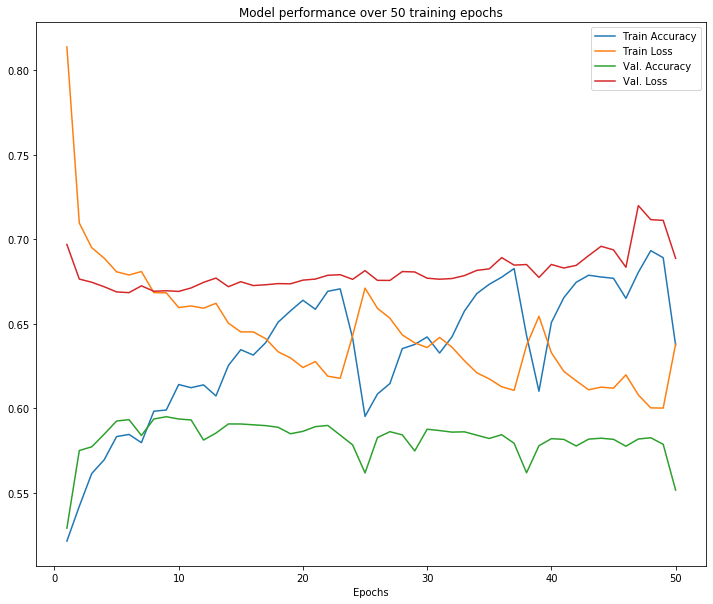

In [36]:
# Visualize loss and accuracy over training epochs
x = [i for i in range(1, 51)]

plt.figure(figsize=(12, 10))
plt.plot(x, history.history['acc'], label='Train Accuracy')
plt.plot(x, history.history['loss'], label='Train Loss')
plt.plot(x, history.history['val_acc'], label='Val. Accuracy')
plt.plot(x, history.history['val_loss'], label='Val. Loss')
plt.title('Model performance over 50 training epochs')
plt.xlabel('Epochs')
plt.legend()
plt.show();

## Evaluating the best model

In [49]:
import keras

model = tf.keras.models.load_model('/content/drive/My Drive/helpful-reviews/gru_model_3.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [63]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 128)          25600000  
_________________________________________________________________
gru_12 (GRU)                 (None, 100, 25)           11550     
_________________________________________________________________
gru_13 (GRU)                 (None, 100, 25)           3825      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 25)                0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)              

In [67]:
# Evaluate the best model using holdout data
model.evaluate(X_test_tok_pad, y_test, batch_size=2048)

39358/39358 [==============================] - 1s 28us/sample - loss: 0.6686 - acc: 0.5939


[0.668626335758317, 0.59390724]

In [0]:
# Generate a few sample predictions (1 = "helpful", 0 = not helpful)

sample = X_train_tok_pad[:10]
actual = y_train[:10]

predictions = model.predict(sample)


In [85]:
sample_results = pd.concat([pd.Series([float(p) for p in predictions]), pd.Series(actual).reset_index()], axis=1)
sample_results.columns = ['Probability_of_helpfulness', 'Original_index', 'Actual_helpfulness']
sample_results.set_index(keys='Original_index', inplace=True)
sample_results

,Probability_of_helpfulness,Actual_helpfulness
Original_index,,
38332,0.518994,0
348970,0.607992,0
186848,0.307253,0
316354,0.520505,1
390134,0.289003,0
59957,0.293462,0
188544,0.538546,1
331042,0.338095,0
250613,0.562134,1


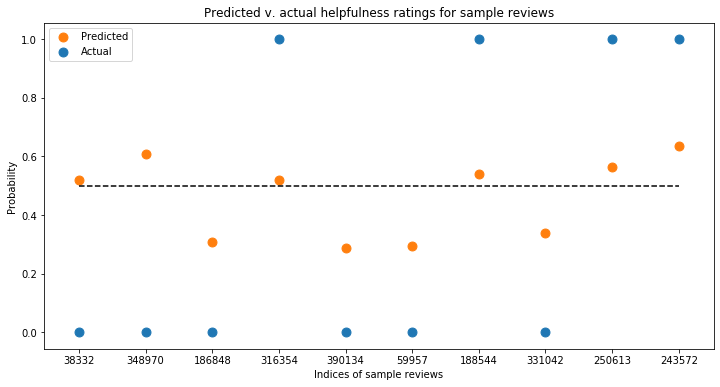

In [97]:
x = [i for i in range(len(sample_results))]
y = [0.5 for i in range(len(sample_results))]

plt.figure(figsize=(12,6))
plt.plot(x, y, linestyle='--', color='k')
plt.scatter(x, sample_results.Probability_of_helpfulness, label='Predicted', color='tab:orange', s=80)
plt.scatter(x, sample_results.Actual_helpfulness, label='Actual', color='tab:blue', s=80)
plt.title('Predicted v. actual helpfulness ratings for sample reviews')
plt.xlabel('Indices of sample reviews')
plt.xticks(x, sample_results.index)
plt.ylabel('Probability')
plt.legend()
plt.show();

# Interpretation and recommendations

The biggest takeaway from this project is that **"helpfulness" is hard to predict using this dataset**. The vocabularies of "helpful" reviews are very similar to those of the others, and there is no correlation between "helpfulness" and the length or positivity of a review. There are probably other factors influencing readers' decision to rate a review as helpful, such as where a review appears in the list of reviews, or what sort of product was reviewed.

That said, **a model that can predict whether a review will be "helpful" with even a small amount of accuracy can be used to sort reviews so that readers are exposed to the ones more likely to help them**. This can improve user experience and generate new data to help retrain the model. 

The reviews in this dataset were written about food and food-related products sold by Amazon. From the reviews we can gain several important insights about what potential customers find helpful. Coffee, tea, chocolate, and pet foods are the most-discussed products. Flavor/taste is a top concern, as are some specific nutritional concerns (high fructose corn syrup, gluten free). 